### Dentex toothmodel image augmentations ###

In [8]:
import os
import numpy as np
import pandas as pd
import glob
import json
import copy
import random
from pathlib import Path
import logging
import itertools
from PIL import Image
import datetime
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import patches

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData, fdi_ada_mapping, val_test_split
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xywh2xyxy, xyxy2xywh, clipxywh

print(f'Project module version: {dt.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev16+g367a5b6


### Define data locations for this notebook ###

In [3]:
# Data directory
data_root = os.path.join(os.environ.get('HOME'), 'data')
data_dir = os.path.join(data_root, 'dentex_detection')
model_dir = os.path.join(data_dir, 'model')

# Image directory (after cropping the data)
image_dir = os.path.join(data_dir, 'quadrants')

### Make sure that the data is available ###

In [4]:
# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 2531
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Found {len(file_list)} images.')

Found 2531 images.


### Functions ###

In [7]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

# Quick histogram to show distribution of teeth
def plot_hist(data, ax):
    plt.style.use('default')
    g = sns.histplot(data=data, x='ada', hue='quadrant', 
                     ax=ax, palette='Blues', 
                     discrete=True)
    sns.move_legend(g, "upper right", bbox_to_anchor=(1.15, 1.0), title='Quadrant')
    ax.set(xlabel='Position', ylabel='Annotations')
    return ax

# Category mapping
fdi2ada  = fdi_ada_mapping()
ada2fdi = {v: k for k, v in fdi2ada.items()}

### Load the annotations ###

/app/data/dentex_detection/quadrants


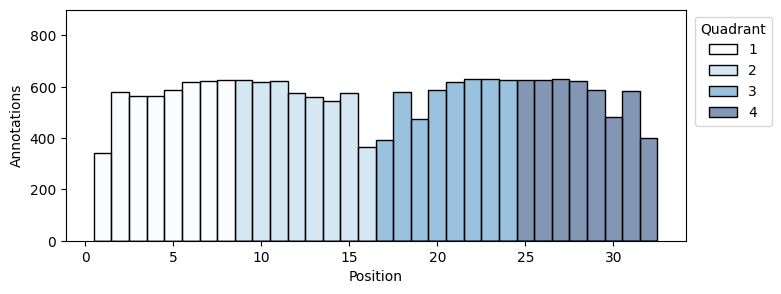

In [10]:
annotations_file_name = 'train_split_250223.parquet'
annotations_file = os.path.join(image_dir, annotations_file_name)
df = pd.read_parquet(annotations_file)
print(image_dir)

# Quick histogram to show distribution of teeth
fig, ax = plt.subplots(figsize=(8, 3))
ax = plot_hist(data=df, ax=ax)
ax.set(ylim=[0, 900], yticks=np.arange(0, 1000, 200))
hist_file_name = 'dentex_annotation_hist.png'
hist_file = os.path.join(data_dir, hist_file_name)
plt.savefig(hist_file, bbox_inches='tight')
plt.show()

### Show some images with bounding boxes ###

In [11]:
display(df.head(2))
file_list = sorted(list(df['file_name'].unique()))

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train


### Set up augmentations ###